### Mike Ogrysko
### CS 766 Information Retrieval and Natural Language Processing

Processing the IMDB movie reviews for sentiment analysis with opinion lexicon
- Opinion Lexicon from the source: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
- Quantize the positive and negative frequencies to 0 and 1
- First 1000 words in Tf-Idf features and compute 10-fold CV classification evaluation performance
- First 1000 TFIDF features with counts of positive and negative opinions
- Compare the ranked features

In [1]:
import csv
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize
import seaborn as sns
import re
from math import log

**Quantize the positive and negative frequencies to 0 and 1**

In [2]:
#combination of stop words and punctuations, also get rid of br
stop_words = stopwords.words('english') + list(punctuation)
stop_words_set = set(stop_words) | set(['br']) | set(['p']) | set(['the']) | set(['this']) | set(['etc'])

#develop tokenizer
def tokenize(text):
    terms = word_tokenize(text)
    #all lower case
    terms = [w.lower() for w in terms]
    #filter stop words
    terms = [w for w in terms if w not in stop_words_set and not w.isdigit()]
    #regex for contractions and other special character strings
    terms = [w for w in terms if not re.search(r'^\W+|\w\'\w+|\'\w+$', w)]
    terms = [w for w in terms if not re.search(r'^[^a-z]+$', w)]
    #regex for words two letters or less and numbers
    terms = [w for w in terms if not re.search(r'^\b\w{1,2}\b|(?<!\S)\d+(?!\S)$', w)]
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    terms = [lemmatizer.lemmatize(w, 'n') for w in terms]
    return terms


In [3]:
Reviews, Sentiments = [], []

with open('movie_data.csv','r', encoding='utf8') as fin:
    reader = csv.reader(fin, delimiter=',', quotechar='"')
    header = next(reader)
    for i, line in enumerate(reader):
        Reviews += [line[0]]
        Sentiments +=[int(line[1])]

N=len(Reviews)
M=len(Sentiments)
print('Total reviews loaded', N)
print('Total sentiments loaded', M)


Total reviews loaded 50000
Total sentiments loaded 50000


In [4]:
#tokenize reviews
Reviews_Tok=[tokenize(review) for review in Reviews]
    

In [5]:
#create positive dict from list
pos_dict = {}
pos_file = open("positive-words.txt", "r")
pos_content = pos_file.readlines()
for i,term in enumerate(pos_content[30:]):
    pos_dict[term.strip('\n')] = i


In [6]:
#create neg dict from list
neg_dict = {}
neg_file = open("negative-words.txt", "r", encoding = "ISO-8859-1")
neg_content = neg_file.readlines()
for i,term in enumerate(neg_content[31:]):
    neg_dict[term.strip('\n')] = i


In [7]:
%%time
#initiate 50kx2 array
opinion_score = np.zeros([N, 2], dtype = int)

#get counts of positive and negative terms
for i, review in enumerate(Reviews_Tok):
    #initialize counts
    pos_count = 0
    neg_count = 0
    for term in review:
        if term in pos_dict:
            pos_count += 1
        if term in neg_dict:
            neg_count += 1
    opinion_score[i][0] = pos_count
    opinion_score[i][1] = neg_count


CPU times: user 714 ms, sys: 5.43 ms, total: 719 ms
Wall time: 719 ms


In [8]:
#sanity check
print(f'Review 1 = {opinion_score[0][0]} pos {opinion_score[0][1]} neg')
print(f'Review 2 = {opinion_score[1][0]} pos {opinion_score[1][1]} neg')
print(f'Review 3 = {opinion_score[2][0]} pos {opinion_score[2][1]} neg')

Review 1 = 8 pos 13 neg
Review 2 = 13 pos 10 neg
Review 3 = 13 pos 20 neg


In [9]:
#create prediction list
predict = [1 if opinion_score[i][0] >= opinion_score[i][1] else 0 for i in range(N)]

In [10]:
#sanity check
print(f'Sentiment review 1 = {predict[0]}')
print(f'Sentiment review 2 = {predict[1]}')
print(f'Sentiment review 3 = {predict[2]}')

Sentiment review 1 = 0
Sentiment review 2 = 1
Sentiment review 3 = 0


In [11]:
#generate accuracy and count correct
print(f"Accuracy Score: {accuracy_score(Sentiments, predict)}")
print(f"# Correct: {accuracy_score(Sentiments, predict, normalize=False)}")

Accuracy Score: 0.72476
# Correct: 36238


**First 1000 words in Tf-Idf features and compute 10-fold CV classification evaluation performance**

In [12]:
#tokenize reviews and put them back together as strings
Review_tok_2 = []
for review in Reviews:
    rev = ""
    terms = tokenize(review)
    for term in terms:
        rev += term + ' '
    Review_tok_2.append(rev)

In [13]:
#set tfidf with 1000 max features
tfidf = TfidfVectorizer(max_features=1000)

In [14]:
#svm classifer
svm_lin_2 = Pipeline([('tfidf', tfidf), ('clf', LinearSVC(class_weight='balanced'))])

In [15]:
#stratifiedKFold will require indexable data structure
Revs = pd.Series(Review_tok_2)
Sents = pd.Series(Sentiments)

In [16]:
#fn for stratified kfold
def kfold_eval_docs(_clf, _Xdocs, _ydocs):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_Xdocs, _ydocs):
        _clf.fit(_Xdocs[train_index], _ydocs[train_index])
        y_pred = _clf.predict(_Xdocs[test_index])
        acc += [accuracy_score(_ydocs[test_index], y_pred)]

    return np.array(acc)

In [17]:
%%time
#get accuracy using skfold
acc = kfold_eval_docs(svm_lin_2, Revs, Sents)
print(f'Support Vector Machine (linear SVC) CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Support Vector Machine (linear SVC) CV accuracy=0.863 0.004
CPU times: user 34.6 s, sys: 560 ms, total: 35.2 s
Wall time: 35.1 s


**First 1000 TFIDF features with counts of positive and negative opinions**

In [18]:
#normalize opinion score
opinion_score_norm = Normalizer().transform(opinion_score)

In [19]:
#set tfidf with 1000 max features
tfidf = TfidfVectorizer(max_features=1000)

In [20]:
#fit reviews to tfidf
X_tfidf = tfidf.fit_transform(Review_tok_2)

In [21]:
#convert X_tfidf to array
X_tfidf_arr = X_tfidf.toarray()

In [22]:
#combine X_tfidf and opinion_score
X_tfidf_comb = np.append(X_tfidf_arr, opinion_score_norm, axis=1)

In [23]:
#svm classifer
svm_lin_3 = Pipeline([('clf', LinearSVC(class_weight='balanced'))])

In [24]:
#stratifiedKFold will require indexable data structure
Sents = pd.Series(Sentiments)

In [25]:
%%time
#get accuracy using skfold
acc = kfold_eval_docs(svm_lin_3, X_tfidf_comb, Sents)
print(f'Support Vector Machine (linear SVC) CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')

Support Vector Machine (linear SVC) CV accuracy=0.867 0.004
CPU times: user 18.3 s, sys: 2.74 s, total: 21 s
Wall time: 11.3 s


**Compare the ranked features**

In [26]:
#grab classifier
classifier = svm_lin_2.named_steps['clf']
#grab coefficients
coef = classifier.coef_[0].ravel()
#get the top coefs for each sentiment
pos_coef = np.argsort(coef)[-10:]
neg_coef = np.argsort(coef)[:10]

In [27]:
#get the feature names
cv = svm_lin_2.named_steps['tfidf']
feature_names = cv.get_feature_names_out()

In [28]:
#get sentiment 1 features and coefficients
feat1 = feature_names[pos_coef]
coef1 = coef[pos_coef]

#get sentiment 0 features and coefficients
feat0 = feature_names[neg_coef]
coef0 = coef[neg_coef]

In [29]:
#convert to dicts
feat1_dict = {feat1[i]: coef1[i] for i in range(len(feat1))}
feat0_dict = {feat0[i]: coef0[i] for i in range(len(feat0))}
#sort dicts by value
sort_feat1_dict = dict(sorted(feat1_dict.items(), key=lambda kv:kv[1],reverse=True))
sort_feat0_dict = dict(sorted(feat0_dict.items(), key=lambda kv:kv[1],reverse=False))
#convert dicts to lists
sort_feat1_list = list(sort_feat1_dict.items())
sort_feat0_list = list(sort_feat0_dict.items())

In [30]:
#grab classifier
classifier_3 = svm_lin_3.named_steps['clf']


In [31]:
#grab coefficients
coef_3 = classifier_3.coef_[0].ravel()
#get the top coefs for each sentiment
pos_coef_3 = np.argsort(coef_3)[-10:]
neg_coef_3 = np.argsort(coef_3)[:10]

In [32]:
#get the feature names
#cv = svm_lin_2.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

In [33]:
#get sentiment 1 features and coefficients
feat1_3 = feature_names[pos_coef]
coef1_3 = coef[pos_coef]

#get sentiment 0 features and coefficients
feat0_3 = feature_names[neg_coef]
coef0_3 = coef[neg_coef]

In [34]:
#convert to dicts
feat1_dict_3 = {feat1_3[i]: coef1_3[i] for i in range(len(feat1_3))}
feat0_dict_3 = {feat0_3[i]: coef0_3[i] for i in range(len(feat0_3))}
#sort dicts by value
sort_feat1_dict_3 = dict(sorted(feat1_dict_3.items(), key=lambda kv:kv[1],reverse=True))
sort_feat0_dict_3 = dict(sorted(feat0_dict_3.items(), key=lambda kv:kv[1],reverse=False))
#convert dicts to lists
sort_feat1_list_3 = list(sort_feat1_dict_3.items())
sort_feat0_list_3 = list(sort_feat0_dict_3.items())

In [35]:
#build feature and importance lists for plots
q2_feat = []
q2_feat_imp = []
q3_feat = []
q3_feat_imp = []
for i in range(10):
    q2_feat.append(sort_feat1_list[i][0])
    q2_feat_imp.append(sort_feat1_list[i][1])
    q3_feat.append(sort_feat1_list_3[i][0])
    q3_feat_imp.append(sort_feat1_list_3[i][1])
for i in range(10):    
    q2_feat.append(sort_feat0_list[i][0])
    q2_feat_imp.append(sort_feat0_list[i][1])
    q3_feat.append(sort_feat0_list_3[i][0])
    q3_feat_imp.append(sort_feat0_list_3[i][1])
    

In [36]:
#build color lists for plots
q2_color = []
q3_color = []
for j in range(20):
    if q2_feat_imp[j] > 0:
        q2_color.append("green")
    if q2_feat_imp[j] <= 0:
        q2_color.append("red")
    if q3_feat_imp[j] > 0:
        q3_color.append("green")
    if q3_feat_imp[j] <= 0:
        q3_color.append("red")
    

In [37]:
#print top 10 for each sentiment
print(f"\n\t\t\tFirst 1000 TFIDF features")
print(f"\tSentiment 1\t\t\tSentiment 0")
print(f"Importance\tTerm\t\tImportance\tTerm")
for i in range(10):
    print(f"{sort_feat1_list[i][1]:3f}\t{sort_feat1_list[i][0]:16s}{sort_feat0_list[i][1]:3f}\t{sort_feat0_list[i][0]}")
    

print(f"\t\t\tQuestion 3")
print(f"\tSentiment 1\t\t\tFirst 1000 TFIDF features with counts of positive and negative opinions")
print(f"Importance\tTerm\t\tImportance\tTerm")
for i in range(10):
    print(f"{sort_feat1_list_3[i][1]:3f}\t{sort_feat1_list_3[i][0]:16s}{sort_feat0_list_3[i][1]:3f}\t{sort_feat0_list_3[i][0]}")



			First 1000 TFIDF features
	Sentiment 1			Sentiment 0
Importance	Term		Importance	Term
2.770550	excellent       -4.647828	worst
2.232172	perfect         -3.918829	waste
2.202225	amazing         -3.659435	awful
2.191884	great           -2.751775	boring
2.026107	superb          -2.696372	dull
1.966061	wonderful       -2.606340	poorly
1.871283	hilarious       -2.516190	terrible
1.825347	fantastic       -2.478946	fails
1.812483	perfectly       -2.420251	horrible
1.777352	favorite        -2.382722	bad
			Question 3
	Sentiment 1			First 1000 TFIDF features with counts of positive and negative opinions
Importance	Term		Importance	Term
2.770550	expected        -4.647828	worst
2.232172	period          -3.918829	waste
2.202225	amazing         -3.659435	baby
2.191884	guy             -2.751775	box
2.026107	supposed        -2.696372	dvd
1.966061	wonderful       -2.606340	positive
1.871283	hollywood       -2.516190	the
1.825347	father          -2.478946	familiar
1.812483	person          -2.420251

Text(0.5, 0, 'Feature')

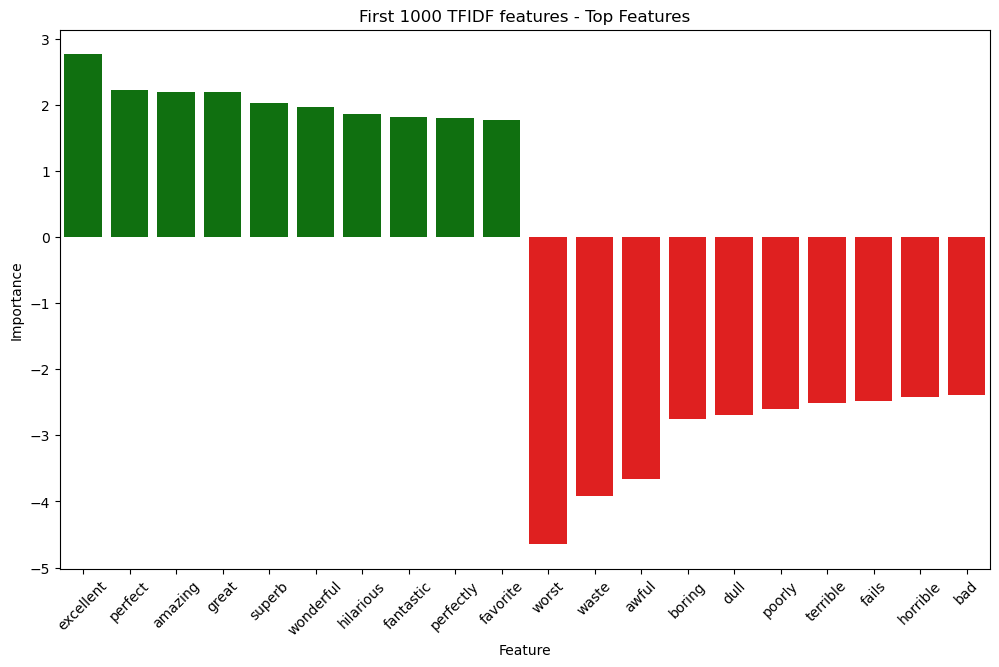

In [38]:
#plot First 1000 TFIDF features results
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x=q2_feat,
            y=q2_feat_imp,
           palette=q2_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("First 1000 TFIDF features - Top Features")
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")

Text(0.5, 0, 'Feature')

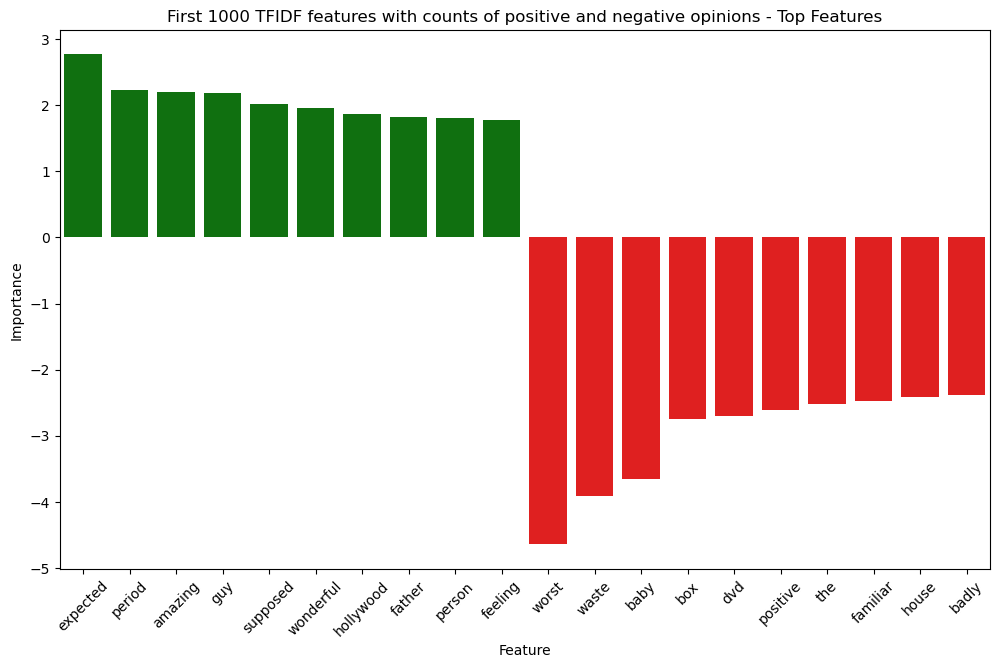

In [39]:
#plot First 1000 TFIDF features with counts of positive and negative opinions results
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x=q3_feat,
            y=q3_feat_imp,
           palette=q3_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("First 1000 TFIDF features with counts of positive and negative opinions - Top Features")
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")